In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [2]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(10)

In [3]:
# %%time
# # Import generic wrappers
# from transformers import AutoModel, AutoTokenizer


# # Define the model repo
# model_name = "vinai/phobert-base"


# # Download pytorch model
# model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
# # Transform input tokens
# inputs = tokenizer("dễ thương ghê ! làm mình nhớ các cậu bạn cùng!", return_tensors="pt")

# # Model apply
# outputs = model(**inputs)
# # print(outputs)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 4

In [6]:
%%time
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
#     df.columns = ['Emotion', 'Sentence']
    df.columns = ['index', 'Emotion', 'Sentence']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

train_df = get_data('train_nor_811.xlsx')
valid_df = get_data('valid_nor_811.xlsx')
test_df = get_data('test_nor_811.xlsx')


# def get_data(path):
#     df = pd.read_excel(path, sheet_name=None)['Sheet1']
# #     df.columns = ['Emotion', 'Sentence']
#     df.columns = ['Emotion', 'Sentence']
#     # unused column
#     # df.drop(columns=['index'], inplace=True)
#     return df

# train_df = get_data('train.xlsx')
# valid_df = get_data('valid.xlsx')
# test_df = get_data('test.xlsx')



# We will use Kfold later
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Emotion)):
    train_df.loc[val_, "kfold"] = fold

CPU times: user 548 ms, sys: 17 ms, total: 565 ms
Wall time: 566 ms


In [7]:
train_df.sample(5)

,Emotion,Sentence,kfold
1029,Anger,hỏi lồn gì lắm thế,0.0
3497,Other,khác xưa thật mà,2.0
2040,Enjoyment,bình yên thật,1.0
6197,Other,ai sai người ấy chịu . đường là để đi nhà là đ...,3.0
792,Enjoyment,tầm tuổi này . họ không còn những áp lực cuộc ...,0.0


In [8]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   6234 non-null   object 
 1   Sentence  6234 non-null   object 
 2   kfold     6234 non-null   float64
dtypes: float64(1), object(2)
memory usage: 146.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   693 non-null    object
 1   Sentence  693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


(None, None)

<Axes: xlabel='Emotion', ylabel='count'>

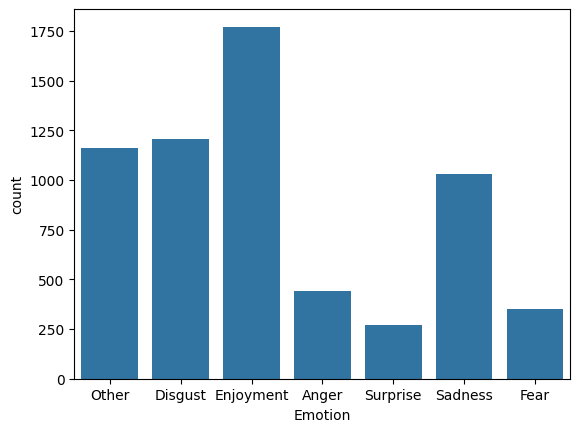

In [9]:
sns.countplot(x='Emotion', data=train_df)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-large", use_fast=False)
# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [11]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Enjoyment':
            return 0
        elif text=='Disgust':
            return 1
        elif text=='Sadness':
            return 2
        elif text=='Anger':
            return 3
        elif text=='Surprise':
            return 4
        elif text=='Fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Emotion'])
        return text, label

Text(0.5, 9.444444444444438, 'Token Count')

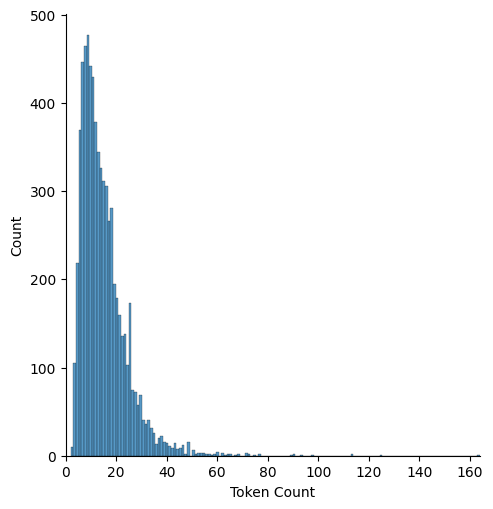

In [12]:
# Distribution of length of Sentence
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [13]:
%%time
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 44.6 µs


In [14]:
%%time
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [15]:
%%time
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)

    return train_loader, valid_loader

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [16]:
%%time
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 1000
    optimizer = AdamW(model.parameters(), lr=3e-4)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'Model_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/6
------------------------------
Train Accuracy: 0.25540106951871655 Loss: 1.8223730820376858
Valid Accuracy: 0.2841565105837075 Loss: 1.7943075530383052
Epoch 2/6
------------------------------
Train Accuracy: 0.24406417112299464 Loss: 1.8088079909889065
Valid Accuracy: 0.2841565105837075 Loss: 1.788661241531372
Epoch 3/6
------------------------------
Train Accuracy: 0.27101604278074864 Loss: 1.7898364359018755
Valid Accuracy: 0.2841565105837075 Loss: 1.7817716914780286
Epoch 4/6
------------------------------
Train Accuracy: 0.27358288770053474 Loss: 1.7870424077624367
Valid Accuracy: 0.2841565105837075 Loss: 1.7887849759082406
Epoch 5/6
------------------------------
Train Accuracy: 0.28192513368983957 Loss: 1.7820993159093013
Valid Accuracy: 0.2841565105837075 Loss: 1.7737198751799914
Epoch 6/6
------------------------------
Train Accuracy: 0.2838502673796791 Loss: 1.7773388551206004
Valid Accuracy: 0.2841565105837075 Loss: 1.771676372

In [17]:
%%time
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'Model_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [18]:
%%time
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.28      1.00      0.44       193
           1       0.00      0.00      0.00       132
           2       0.00      0.00      0.00       116
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00       129

    accuracy                           0.28       693
   macro avg       0.04      0.14      0.06       693
weighted avg       0.08      0.28      0.12       693

CPU times: user 9.29 s, sys: 2.98 s, total: 12.3 s
Wall time: 14 s


CPU times: user 134 ms, sys: 37.9 ms, total: 172 ms
Wall time: 136 ms


<Axes: >

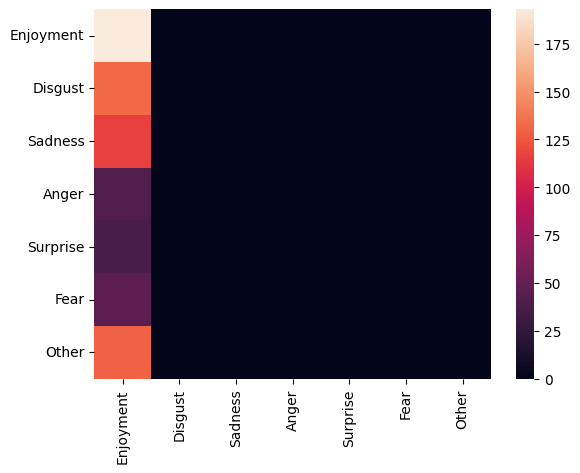

In [19]:
%%time
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

## Visualize Wrong Predicted Label

In [20]:
%%time
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
người ta có bạn bè nhìn vui thật
Predicted: (Enjoyment) --vs-- Real label: (Disgust)
--------------------------------------------------
cho nghỉ viêc mói đúng sao goi là kỷ luật
Predicted: (Enjoyment) --vs-- Real label: (Other)
--------------------------------------------------
kinh vãi 😡
Predicted: (Enjoyment) --vs-- Real label: (Other)
--------------------------------------------------
nhà thì không xa lắm nhưng chưa bao giờ đi vì sợ bị đè bẹp luôn người =)))))
Predicted: (Enjoyment) --vs-- Real label: (Anger)
--------------------------------------------------
bố không thích nộp đấy mày thích ý kiến không
Predicted: (Enjoyment) --vs-- Real label: (Disgust)
--------------------------------------------------
bắt cóc bỏ đĩa . quanh đi quẩn lại chỉ khổ dân đen thôi !
Predicted: (Enjoyment) --vs-- Real label: (Surprise)
--------------------------------------------------
per khi nào bạn có bằng xe ôtô thì bạn mới hiểu . sai thì đã có ca
Pr

## INFERENCES

# New Section

In [21]:
%%time
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
